# Multivariate Logistic Regression
One-vs-All Logistic Regression, also known as One-vs-Rest Logistic Regression, is a technique used for multivariate logistic regression where there are more than two classes to be predicted. It extends the concept of logistic regression from binary classification to multiclass classification.

In multivariate logistic regression, the goal is to predict the probability of each class label based on a set of input features. However, logistic regression models are inherently designed for binary classification, where they estimate the probability of one class relative to the other.

The process of this will be as follows:
1. Implement logistic regression for 2 classes
2. Implement multivariate logistic regression by extending the logistic regression
3. Prepare the dataset
4. Train the model
5. Test the model
6. If possible, improve accuracy

First of all, though, we will define our data types that will be used trough out this solution.

In [2]:
from typing import Callable, List, Tuple
import numpy as np

Feature = float
FeatureVector = List[Feature]
Dataset = List[FeatureVector]

Label = int
Labels = List[Label]

LearningRate = float
Epoch = int

FeatureExtractor = Callable

## Step 1: Logistic Regression

The general case will consist of a dataset of `m` points and `n` features. Thus, the model has `m`
weights (think of them as the generalization of the slope) and one bias. The notation follows:
- The data points are `x`<sup>(`1`)</sup>, `x`<sup>(`2`)</sup>, … , `x`<sup>(`m`)</sup>. Each point is of the for`m` `x`<sup>(`i`)</sup> = (`x`<sub>`1`</sub><sup>(`i`)</sup>, `x`<sub>`2`</sub><sup>(`i`)</sup>, … , `x`<sub>`n`</sub><sup>(`i`)</sup>).
- The corresponding labels are `y`<sub>`1`</sub>, `y`<sub>`2`</sub>, … , `y`<sub>`m`</sub>.
- The weights of the model are `w`<sub>`1`</sub>, `w`<sub>`2`</sub>, … , `w`<sub>`m`</sub>.
- The bias of the model is `b`.

They combine in the formula:

y = w<sub>1</sub>x<sup>(1)</sup> + w<sub>2</sub>x<sup>(2)</sup> + … + w<sub>m</sub>x<sup>(m)</sup> + b,

And `y` can be any one of the various classes `y`<sub>`1`</sub>, `y`<sub>`2`</sub>, … , `y`<sub>`m`</sub>.

The plan here is to be able to guess each `w`<sub>`i`</sub> and `b` so that once given the `x`s the model can predict the value of `y`. and the plan is as follows:
- Randomly generate `w`<sub>`i`</sub> and `b`
- Iteratively improve the `w`<sub>`i`</sub> and `b` so that they are closer to the datapoints
- Return the final formula (slope and intercept)

In [3]:
class LogisticRegression:
    def __init__(self, dataset: Dataset, labels: Labels, learning_rate: LearningRate, epochs: Epoch) -> None:
        self.dataset = dataset
        self.labels = labels
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self) -> Tuple[List[float], float]:
        weights = np.random.random(len(self.dataset[0]))
        bias = np.random.random()

        for _ in range(self.epochs):
            index = np.random.randint(0, len(self.dataset) - 1)
            feature = self.dataset[index]
            label = self.labels[index]

            weights, bias = self._logistic_loss(weights, bias, feature, label)

        return weights, bias

    def predict(self, feature: FeatureVector, weights: List[float], bias: float) -> float:
        z = np.dot(weights, feature) + bias
        return self._sigmoid(z)

    def _logistic_loss(self, weights: List[float], bias: float, feature: FeatureVector, label: Label) -> Tuple[List[float], float]:
        predicted = self.predict(feature, weights, bias)
        error = predicted - label

        weights = [w - (self.learning_rate * error * f) for w, f in zip(weights, feature)]
        bias = bias - (self.learning_rate * error)

        return weights, bias

    def _sigmoid(self, z: float) -> float:
        return 1 / (1 + np.exp(-z))


## Step 2: Multivariate Logistic Regression

In [4]:
class MulticlassLogisticRegression:
    def __init__(self, dataset: Dataset, labels: Labels, learning_rate: LearningRate, epochs: Epoch, feature_extractor: FeatureExtractor) -> None:
        self.dataset = dataset
        self.labels = labels
        self.models = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.feature_extractor = feature_extractor

        self._train()

    def _train(self) -> None:
        for label in self.labels:
            if label not in self.models:
                labels = [1 if x == label else 0 for x in self.labels]
                features = self.feature_extractor(self.dataset)
                model = LogisticRegression(features, labels, self.learning_rate, self.epochs)
                slope, intercept = model.train()
                self.models[label] = (model, slope, intercept)


    def predict(self, feature_vector: FeatureVector) -> int:
        extracted_feature = self.feature_extractor(feature_vector)  # Apply feature extraction
        best_score = 0
        best_label = None

        for label, (model, slope, intercept) in self.models.items():
            score = model.predict(extracted_feature, slope, intercept)

            if score > best_score:
                best_score = score
                best_label = label
        
        return best_label



## Step 3: Prepare the dataset

In [5]:
from mnist import MNIST

mndata = MNIST('./dataset')
mndata.gz = True
training_images, training_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

## Step 4 & 5: Train the model and test it using different hyperparameters

In [6]:
def accuracy(model, images, labels, feature_extractor):
    correct = 0
    images = feature_extractor(images)
    for image, label in zip(images, labels):
        predicted = model.predict(image)
        if predicted == label:
            correct += 1
    return correct / len(images)

### Subroutine: Implement different feature extraction methods.

We have chosen three different methods that we will explain now. The methods we chose are Normalization, Binarization and Sobel Edge Detection.

#### 1. Normalization:
is a common preprocessing step that scales the pixel values to a standardized range, typically between 0 and 1. By normalizing the dataset, you ensure that the input features have a consistent scale, which can help the model converge faster during training and improve its ability to generalize to new data.

#### 2. Binarization
is a simple thresholding technique that converts the pixel values into binary values based on a specified threshold. This can be useful in scenarios where you want to emphasize the presence or absence of certain features. Binarization can help simplify the data and highlight important patterns or edges, potentially making it easier for the model to learn and recognize relevant image features.

#### 3. Sobel edge detection:
is a classic image processing technique that enhances the edges in an image by calculating the gradient magnitude. By detecting and emphasizing edges, you provide the model with more prominent and informative features for classification. The Sobel edge detection method can help the model focus on important transitions and contours, which can improve its ability to distinguish between different classes.

In [7]:
def featurize_normalized_pixel(images):
    images = np.array(images) / 255.0

    return images

In [8]:
def binarize_images(images, threshold=127):
    binarized_images = []
    for image in images:
        binarized_image = np.where(image > threshold, 1.0, 0.0)
        binarized_images.append(binarized_image)
    
    return np.array(binarized_images)

In [9]:
from skimage.feature import hog

def featurize_hog(images):
    # Initialize the HOG descriptor
    hog_descriptor = hog(
        np.array(images),
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm='L2-Hys'
    )

    # Extract HOG features for the images
    features = []
    for image in images:
        feature = hog_descriptor.compute(image)
        features.append(feature)

    return np.array(features)

In [13]:
feature_extractors = {
    # 'binarized_pixel': binarize_images,
    'normalized_pixel': featurize_normalized_pixel,
    # 'featurize_hog': featurize_hog,
}

In [14]:
test_images, test_labels = np.array(test_images), np.array(test_labels)
# learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]
learning_rates = [0.001, 0.01, 0.1]
accuracies = {}

# test the different featuer extractors and learning rates
for feature_extractor_name, feature_extractor in feature_extractors.items():
    accuracies[feature_extractor_name] = []
    for learning_rate in learning_rates:
        model = MulticlassLogisticRegression(training_images, training_labels, learning_rate, 100, feature_extractor)
        print(accuracies)
        accuracies[feature_extractor_name].append(accuracy(model, test_images, test_labels, feature_extractor))

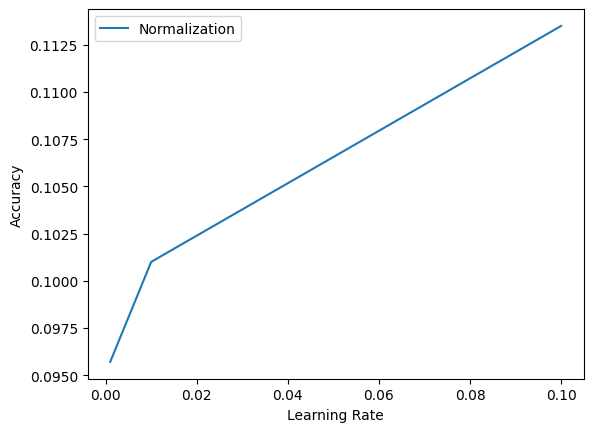

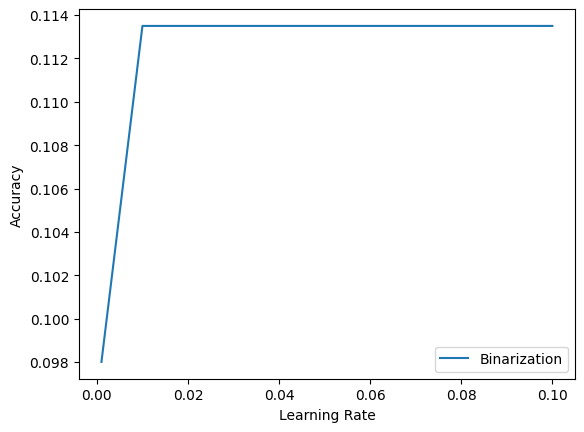

In [ ]:
import matplotlib.pyplot as plt

for feature_extractor_name, accuracy in accuracies.items():
    plt.plot(learning_rates, accuracy, label=feature_extractor_name)

    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [ ]:
print(accuracies)

{'Normalization': [0.0957, 0.101, 0.1135], 'Binarization': [0.098, 0.1135, 0.1135]}
